# Deep Learning Fundamentals — Intro Notebook
**Autonomous Systems B (Intro Lab)**

This notebook introduces the core ideas you will need for the CARLA lab:
- Tensors & arrays
- Feedforward neural networks
- Training loop and backpropagation
- Convolutional neural networks (CNNs)
- Hyperparameter exploration
- Scientific work style (reproducibility, documentation)
**Prerequisites you bring from semesters 1–4:** arrays & data structures, linear algebra, differential equations, probability, signals & systems, embedded programming.


## 1. Tensors & Arrays
**Concept:** Images are 2D arrays (height × width); batches add a dimension. In DL frameworks (e.g., PyTorch), tensors are the generalization of arrays.

**Exercise 1.1 (Explain):**
- Given a batch shaped `(N, C, H, W)`, explain what each letter stands for.
    - N: Number of images
    - C: Number of channels
    - H: Height 
    - W: Width
- What shapes would you expect for grayscale vs. RGB images?
    - Grayscale: 2D array
    - RGB: 3D array

In [32]:
import torch

# Single grayscale image 28x28
img = torch.rand(28, 28)
print("img shape:", img.shape)

# Batch of 64 grayscale images (N, C, H, W)
batch = torch.rand(64, 1, 28, 28)
print("batch shape:", batch.shape)

# Batch of 16 RGB images 64x64
rgb = torch.rand(16, 3, 64, 64)
print("rgb shape:", rgb.shape)

img shape: torch.Size([28, 28])
batch shape: torch.Size([64, 1, 28, 28])
rgb shape: torch.Size([16, 3, 64, 64])


## 2. Feedforward Neural Networks (FFNN)
A layer applies a linear transform followed by a non-linear activation. Stacking layers gives us powerful **function approximators**.

**Key math:** `y = f(Wx + b)`; with ReLU `f(z) = max(0, z)`

**Exercise 2.1 (Reasoning):**
- Why do we need a non-linear activation?
    - In complex tasks like image classification etc, models might not be able to get all necessary patterns from linear functions and transformations so the activation functions helps to solve this by introducing a non-lineairty  which can help capture more complex patterns.
- How does linear algebra (matrices, vectors) appear in a neural net?


In [29]:
import torch.nn as nn

ffnn = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)  # 10 classes
)
ffnn

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)

## 3. Training Loop & Backpropagation
**Process:** 1) forward pass → 2) compute loss → 3) backward pass (gradients) → 4) optimizer step.

**Exercise 3.1 (Exercise):**
- Train the FFNN on MNIST for 3–5 epochs.
- Plot training loss per epoch and test accuracy.
- Interpret the plot: what does a decreasing loss indicate?
   - a decreasing loss indicates a neural net with better weight parameters that help it fit the training data better.


Epoch 1: loss=1.2313
Epoch 2: loss=0.4905
Epoch 3: loss=0.3931
Epoch 4: loss=0.3539
Epoch 5: loss=0.3301


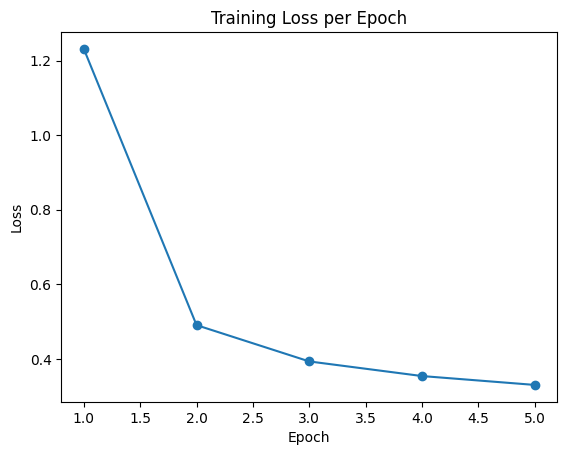

Test Accuracy: 91.49%


In [30]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

# Data loaders
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ffnn.to(device)

loss_fn = nn.CrossEntropyLoss() # classification loss, MSE for regression
optimizer = optim.SGD(model.parameters(), lr=0.01) #gradient descent

train_losses = []

for epoch in range(5):  # adjust epochs as needed
    model.train()
    running = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item()
    avg_loss = running / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: loss={avg_loss:.4f}")

# Plot loss
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate
def accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

test_acc = accuracy(test_loader)
print(f"Test Accuracy: {test_acc*100:.2f}%")

## 4. Convolutional Neural Networks (CNNs)
CNNs learn **local filters** that act like edge/line detectors. Weight sharing reduces parameters and captures spatial patterns.

**Exercise 4.1 (Exercise):**
- Train the CNN below on MNIST for 3 epochs.
- Compare accuracy vs FFNN.
- Visualize the first-layer filters and describe what you see.


[CNN] Epoch 1: loss=1.2244
[CNN] Epoch 2: loss=0.3711
[CNN] Epoch 3: loss=0.3007


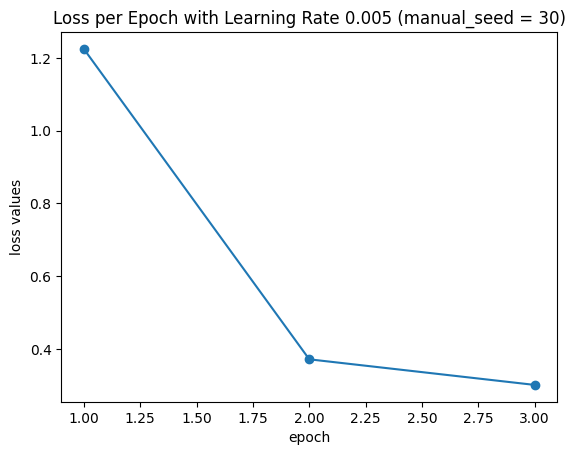

CNN Test Accuracy: 92.44%
FFNN Test Accuracy: 91.49%


In [31]:
seed = 30
torch.manual_seed(seed)

cnn = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*7*7, 10)
).to(device)

optimizer = optim.SGD(cnn.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()
loss_values = []

for epoch in range(3):
    cnn.train()
    running = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        pred = cnn(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item()
    loss_values.append(running/len(train_loader))
    print(f"[CNN] Epoch {epoch+1}: loss={running/len(train_loader):.4f}")

plt.plot(range(1, len(loss_values)+1), loss_values, marker='o')
plt.title("Loss per Epoch with Learning Rate 0.005 (manual_seed = 30)")
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.show()

# Evaluate
def acc(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct/total

print(f"CNN Test Accuracy: {acc(cnn, test_loader)*100:.2f}%")
print(f"FFNN Test Accuracy: {acc(ffnn, test_loader)*100:.2f}%")

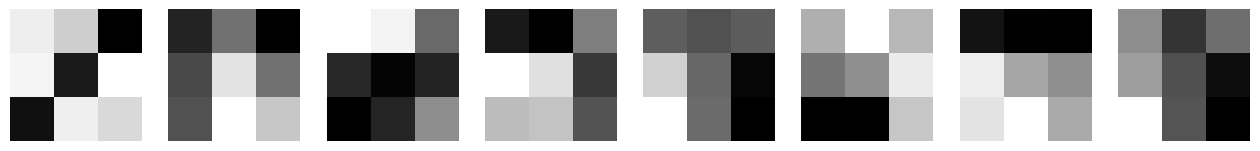

In [ ]:
# Visualize first-layer filters
import matplotlib.pyplot as plt

with torch.no_grad():
    w = cnn[0].weight.cpu().clone()  # shape: (out_channels, in_channels, kH, kW)
w = w[:,0,:,:]  # take first input channel
fig, axes = plt.subplots(1, w.shape[0], figsize=(w.shape[0]*2, 2))
for i, ax in enumerate(axes):
    ax.imshow(w[i], cmap='gray')
    ax.axis('off')
plt.show()

## 5. Hyperparameters & Stability (Control Analogy)
- **Learning rate** too high → divergence/oscillation (like unstable feedback).
- **Batch size** affects gradient noise and speed.
- **Model size** trades capacity vs overfitting.

**Exercise 5.1 (Experiment):**
- Train the CNN with LR in {0.005, 0.05, 0.5}.
- Plot the loss per epoch for each LR and compare. What patterns do you see?
    - 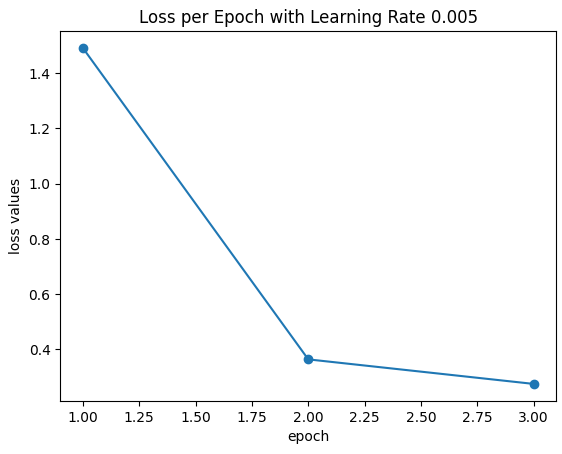  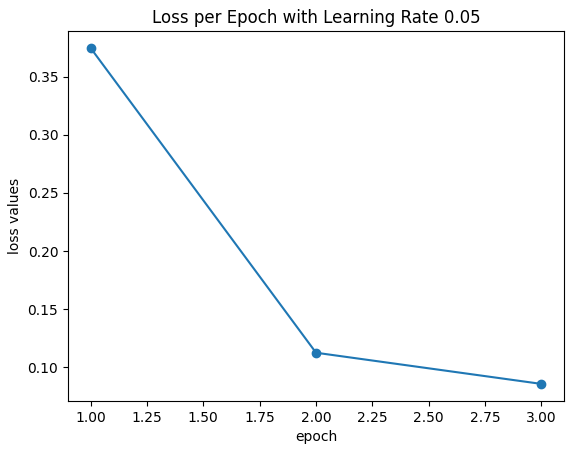 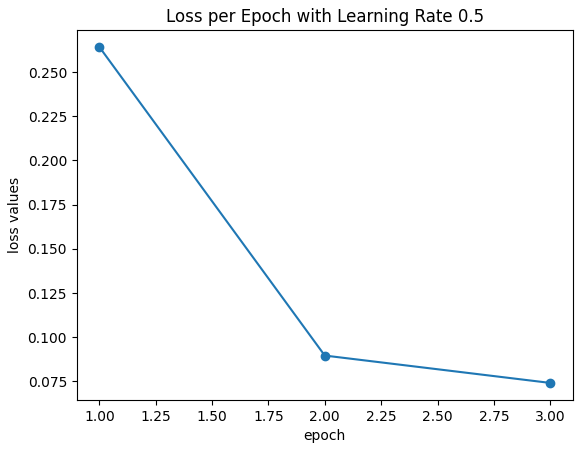


## 6. Scientific Work Style
**Reproducibility checklist:**
- Fix random seeds
- Record dataset version & preprocessing
- Keep configs in a file (YAML/JSON)
- Version control (Git commits)
- Save model with metadata (date, seed, commit)

**Exercise 6.1:**
- Set a manual seed and re-run a short training. Compare results.
  - 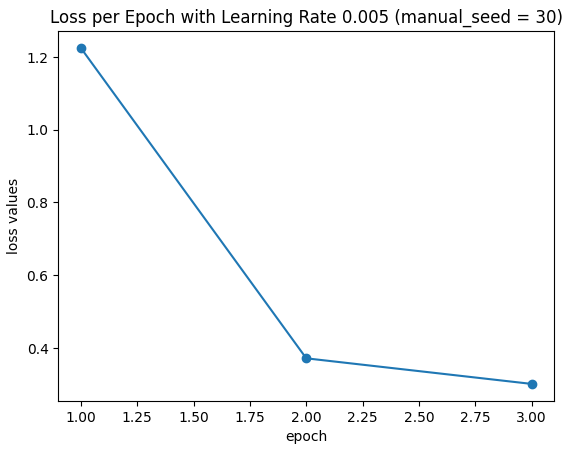 
- Write a short note on what changed and why reproducibility matters.
   - Different losses even at the same learning rate. Reproducibility matters because the training phase should be deterministic, so every thing from the training and testing data set to the weights and biases should remain the same which seeding aids.


---
## 7. Math Deep Dive — Backpropagation (Chain Rule)

We derive gradients for a **1-hidden-layer** classifier.

**Model (row-vector convention):**
- Input \(x \in \mathbb{R}^{d}\)
- Hidden pre-activation \(z = x W_1 + b_1\), \(W_1 \in \mathbb{R}^{d \times h}\), \(b_1 \in \mathbb{R}^{h}\)
- Hidden activation \(h = \phi(z)\) (use ReLU or sigmoid)
- Logits \(o = h W_2 + b_2\), \(W_2 \in \mathbb{R}^{h \times K}\), \(b_2 \in \mathbb{R}^{K}\)
- Predicted probabilities \(p = \mathrm{softmax}(o)\)

**Loss (cross-entropy for one sample with class \(y\))**: \(\mathcal{L} = -\log p_y\).

**Gradients:**

1. \(\displaystyle \frac{\partial \mathcal{L}}{\partial o} = p - y_{\text{onehot}}\)  \hfill (softmax + CE combo)

2. \(\displaystyle \frac{\partial \mathcal{L}}{\partial W_2} = h^\top \, \frac{\partial \mathcal{L}}{\partial o}\), \qquad
   \(\displaystyle \frac{\partial \mathcal{L}}{\partial b_2} = \frac{\partial \mathcal{L}}{\partial o}\)

3. Back to hidden: \(\displaystyle \frac{\partial \mathcal{L}}{\partial h} = \frac{\partial \mathcal{L}}{\partial o} \, W_2^\top\)

4. Through activation: \(\displaystyle \frac{\partial \mathcal{L}}{\partial z} = \frac{\partial \mathcal{L}}{\partial h} \odot \phi'(z)\)

   - ReLU: \(\phi'(z_i) = \mathbb{1}[z_i > 0]\)
   - Sigmoid: \(\phi'(z_i) = \sigma(z_i)(1-\sigma(z_i))\)

5. First layer: \(\displaystyle \frac{\partial \mathcal{L}}{\partial W_1} = x^\top \, \frac{\partial \mathcal{L}}{\partial z}\), \qquad
   \(\displaystyle \frac{\partial \mathcal{L}}{\partial b_1} = \frac{\partial \mathcal{L}}{\partial z}\)

These follow from the **chain rule** and matrix calculus. For a batch, average over samples.


### 7.1 Numerical Gradient Check (Finite Differences)
We verify the analytical gradient against a finite-difference approximation:
\[\frac{\partial \mathcal{L}}{\partial \theta} \approx \frac{\mathcal{L}(\theta + \epsilon) - \mathcal{L}(\theta - \epsilon)}{2\epsilon}\]

In [28]:
import torch, torch.nn as nn
torch.manual_seed(0)

# Tiny network and single batch for gradient check
x = torch.randn(4, 5)      # 4 samples, 5 features
y = torch.tensor([0,1,2,1])  # 3 classes total
K = 3

model = nn.Sequential(
    nn.Linear(5, 4),
    nn.ReLU(),
    nn.Linear(4, K)
)
loss_fn = nn.CrossEntropyLoss()

# Analytical gradient
def forward_loss(m):
    logits = m(x)
    return loss_fn(logits, y)

loss = forward_loss(model)
loss.backward()

analytical = model[0].weight.grad.detach().clone()  # check first layer weight grads

# Finite difference on a single parameter (for speed)
eps = 1e-4
m2 = nn.Sequential(
    nn.Linear(5, 4),
    nn.ReLU(),
    nn.Linear(4, K)
)
# copy parameters
with torch.no_grad():
    for p, q in zip(m2.parameters(), model.parameters()):
        p.copy_(q)

i,j = 0,0  # check W1[i,j]
with torch.no_grad():
    w = m2[0].weight
    w[i,j] += eps
lp = forward_loss(m2).item()
with torch.no_grad():
    w[i,j] -= 2*eps
lm = forward_loss(m2).item()
numgrad = (lp - lm) / (2*eps)

print("Analytical grad   :", analytical[i,j].item())
print("Numerical approx  :", numgrad)

Analytical grad   : -0.01419816818088293
Numerical approx  : -0.01430511474609375


---
## 8. Math Deep Dive — Convolution Arithmetic

For 1D (extend to 2D per dimension):

\[\text{out\_len} = \left\lfloor \frac{(L_{\text{in}} + 2p - k)}{s} \right\rfloor + 1\]

For 2D images (height/width independently):
\[\text{out\_H} = \left\lfloor \frac{(H + 2p - k)}{s} \right\rfloor + 1,\quad
  \text{out\_W} = \left\lfloor \frac{(W + 2p - k)}{s} \right\rfloor + 1\]

- \(k\): kernel size, \(s\): stride, \(p\): padding.
- **Receptive field** grows with stacked layers; pooling reduces spatial size.

**Example:** Input \(64\\times64\), \(k=3\), \(s=2\), \(p=1\) ⇒ out dims: \((64+2-3)/2+1 = 32\).


In [31]:
# Sanity check with PyTorch
import torch, torch.nn as nn
x = torch.randn(1, 3, 64, 64)
conv = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)
y = conv(x)
print('Output shape should be (1, 8, 32, 32):', y.shape)

Output shape should be (1, 8, 32, 32): torch.Size([1, 8, 32, 32])


---
## 9. Metrics & Losses Recap

- **Cross-Entropy (classification)** couples softmax and negative log-likelihood.
- **Accuracy** is not enough for imbalanced data.
- **Precision / Recall / F1** for the positive class (e.g., pedestrians) matter in safety.
- **Optimizers:** SGD (with momentum), Adam. Learning rate ↔ stability.

**Exercise 9.1:** For your MNIST or custom dataset, compute precision/recall/F1 for one class.

In [32]:
import torchmetrics
from torchmetrics import Precision, Recall, F1Score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

seed = 30
torch.manual_seed (seed)

precision = Precision("multiclass", num_classes = 3)
recall = Recall("multiclass", num_classes = 3)
F1 = F1Score("multiclass", num_classes = 3)

train_x = torch.randn(5, 1, 64, 64)
test_x = torch.randn(15, 1, 64, 64)
train_y = torch.tensor([0, 1, 1, 2, 0])
test_y = torch.tensor([1,2,1,0,0,1,2,1,0,0,1,2,1,0,2])

cnn = nn.Sequential(nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(16*16*8, 3)
                    )

optimizer = optim.SGD(cnn.parameters(), lr=0.1)

for epoch in range(100):
    cnn.train()
    running = 0.0
    pred = cnn(train_x)
    loss = nn.CrossEntropyLoss()(pred, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running += loss.item()
    print(f"Epoch {epoch +1} -- loss per epoch: {running/len(train_x)}")

print(F.softmax(pred, dim = 1))
print(torch.argmax(F.softmax(pred, dim = 1), dim =1 ))

# model evaluation
cnn.eval()
with torch.no_grad():
    test = cnn(test_x)
    recall(test, test_y)
    precision(test, test_y)
    F1(test, test_y)

print(F.softmax(test, dim = 1))
print(torch.argmax(F.softmax(test, dim = 1), dim =1 ))

print(f"Precision: {precision.compute().item()}")
print(f"Recall: {recall.compute().item()}")
print(f"F1 score: {F1.compute().item()}")






Epoch 1 -- loss per epoch: 0.1853782057762146
Epoch 2 -- loss per epoch: 0.2125450611114502
Epoch 3 -- loss per epoch: 5.405137252807617
Epoch 4 -- loss per epoch: 0.2049569606781006
Epoch 5 -- loss per epoch: 0.16572847366333007
Epoch 6 -- loss per epoch: 0.12691786289215087
Epoch 7 -- loss per epoch: 0.08531114459037781
Epoch 8 -- loss per epoch: 0.04672952294349671
Epoch 9 -- loss per epoch: 0.023043604195117952
Epoch 10 -- loss per epoch: 0.013223206996917725
Epoch 11 -- loss per epoch: 0.008915768563747406
Epoch 12 -- loss per epoch: 0.006646572053432465
Epoch 13 -- loss per epoch: 0.005279768630862236
Epoch 14 -- loss per epoch: 0.00437140204012394
Epoch 15 -- loss per epoch: 0.0037249136716127396
Epoch 16 -- loss per epoch: 0.003240973502397537
Epoch 17 -- loss per epoch: 0.00286482572555542
Epoch 18 -- loss per epoch: 0.002563599310815334
Epoch 19 -- loss per epoch: 0.002318103983998299
Epoch 20 -- loss per epoch: 0.0021140515804290772
Epoch 21 -- loss per epoch: 0.001942185685